In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# %cd /content/drive/My Drive/Colab Notebooks/GAN_IQ_data
%cd /content/drive/My Drive//GAN_IQ_data

[Errno 2] No such file or directory: '/content/drive/My Drive//GAN_IQ_data'
/content


## Importing the neccesary packages

In [ ]:
import h5py
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization, Reshape
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import os
from datetime import datetime
from numpy import trace
from numpy import iscomplexobj
from numpy.random import random
from scipy.linalg import sqrtm

## Reading the hdf5 POWDER file

In [ ]:
# Open the HDF5 file and read the dataset
file_name = 'trace-2020-9-23-13-34-41_1x2x1_LOC8.hdf5'
with h5py.File(file_name, 'r') as f:
    data = f['/Data/Pilot_Samples'][:]

    # Display the file structure
    def print_attrs(name, obj):
        print(name)
        for key, val in obj.attrs.items():
            print(f"    {key}: {val}")

    f.visititems(print_attrs)

Data
    BEACON_SEQ_TYPE: ['gold_ifft']
    BS_BEACON_ANT: [0]
    BS_BEAMSWEEP: [1]
    BS_CH_PER_RADIO: [2]
    BS_FRAME_LEN: [15]
    BS_FRAME_SCHED: ['GGGGGGGPGGGGGGG']
    BS_NUM_ANT: [2]
    BS_NUM_CELLS: [1]
    BS_RX_GAIN_A: [90.]
    BS_RX_GAIN_B: [90.]
    BS_SDR_ID: ['RF3E000119']
    BS_SDR_NUM_PER_CELL: ['1']
    BS_TX_GAIN_A: [60.]
    BS_TX_GAIN_B: [60.]
    CL_MODULATION: ['QPSK']
    CL_NUM: [1]
    CP_LEN: [0]
    FFT_SIZE: [64]
    FREQ: [2.5e+09]
    OFDM_PILOT: [ 0.15625     0.         -0.00512125 -0.12032513  0.0397497  -0.11115794
  0.09683188  0.08279791  0.02111177  0.02788592  0.05982384 -0.08770676
 -0.11513121 -0.0551805  -0.03831597 -0.10617091  0.09754126 -0.02588835
  0.05333773  0.00407633  0.00098898 -0.11500464 -0.13680488 -0.04737981
  0.02447585 -0.0585318   0.05866877 -0.014939   -0.02248321  0.16065733
  0.11923909 -0.00409559  0.0625     -0.0625      0.03691794  0.09834415
 -0.05720635  0.03929859 -0.13126261  0.06522723  0.08221832  0.09235655
  

## Getting the LTS frames as $\mathbb{R}^{8192}$ vector

Dimension of 8192 correspond to 4096 IQ samples.

The following file has 4000 LTS frame vectors.

In [ ]:
real_samples = data[:,0,0,0,:]/(2**15)

In [ ]:
train_r_frms = real_samples.copy()
print(train_r_frms.shape)

(4000, 8192)


##Specify the Input Noise $(z)$ dimension size

In [ ]:
latent_dim = 200  # Dimension of the latent space

##Generator Architecture

In [ ]:
# Generator model
def build_generator(latent_dim):
    model = Sequential()
    model.add(Dense(2048, input_dim=latent_dim))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(4096))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(4096))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(2048))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(real_samples.shape[1], activation='linear'))
    model.add(Reshape((real_samples.shape[1],)))
    return model

## Discriminator Architecture

In [ ]:
# Discriminator model
def build_discriminator(input_shape):
    model = Sequential()
    model.add(Dense(2048, input_shape=input_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(4096))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(2048))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    return model

## GAN based on the Generator and Discriminator

In [ ]:
# GAN model combining generator and discriminator
def build_gan(generator, discriminator):
    model = Sequential()
    model.add(generator)
    discriminator.trainable = False
    model.add(discriminator)
    return model

## Initialize the GAN model

In [ ]:
# Instantiate models
discriminator = build_discriminator((train_r_frms.shape[1],))
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])

generator = build_generator(latent_dim)
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

## Loading saved models

Our Training regime saves the GAN model at every 1000 iterations. Suppose if we run the model for longer iterations (say 30000) and our Google Colab Runtime session crashed at 25000 iterations, we can use this code to load the GAN model saved at 25000, provided we specify the path on where the file for the saved GAN model (for the generator and discriminator) is located.



*Do not run the cell immediately below if you are starting from Iteration 1 (or starting training the model afresh)*

In [ ]:
generator.load_weights('TF_GAN_Laxmanv2_Checkpoints_2024-11-05_08-48-30/generator_model_epoch_20000.h5')
discriminator.load_weights('TF_GAN_Laxmanv2_Checkpoints_2024-11-05_08-48-30/discriminator_model_epoch_20000.h5')

## Training code

In [ ]:
# Training parameters
iterations = 3
batch_size = 512
half_batch = batch_size // 2

# Arrays to store the loss and accuracy
dt_losses = []
gt_losses = []
dt_accuracies = []
durations = []

# Directory to save checkpoints
current_time = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
checkpoint_dir = f"GAN_checkpoints_{current_time}"
os.makedirs(checkpoint_dir, exist_ok=True)



# Training the GAN
for iteration in range(1,iterations+1):


    idx = np.random.randint(0, train_r_frms.shape[0], half_batch)
    real_data = train_r_frms[idx]



    #Generate Noise vectors
    noise = np.random.normal(0, 1, (half_batch, latent_dim))
    gen_data = generator.predict(noise)


    # Train Discriminator
    dt_loss_real = discriminator.train_on_batch(real_data, np.ones((half_batch, 1)))
    dt_loss_fake = discriminator.train_on_batch(gen_data, np.zeros((half_batch, 1)))
    dt_loss = 0.5 * np.add(dt_loss_real, dt_loss_fake)
    dt_losses.append(dt_loss[0])
    dt_accuracies.append(100 * dt_loss[1])

    # Train Generator
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    valid_y = np.ones((batch_size, 1))
    gt_loss = gan.train_on_batch(noise, valid_y)
    gt_losses.append(gt_loss)




    # Print the progress for every 50 iterations in terms of Discriminator, Generator Loss values
    # and Generator Accuracy

    if iteration % 50 == 0 or iteration == iterations or iteration == 1:
        print(f" Iteration : {iteration} | [D Training loss: {dt_loss[0]} | D Training accuracy: {100 * dt_loss[1]}] [G Training loss: {gt_loss}]")


        # Save the model at every 1000 iterations

        if iteration % 1000 == 0 or iteration == iterations or iteration == 1:

                generator.save(f"{checkpoint_dir}/generator_model_{iteration}iter.h5")
                discriminator.save(f"{checkpoint_dir}/discriminator_model_epoch_{iteration}.h5")
                print(f"Model checkpoint saved at iteration {iteration}")

    # Save the Loss and Accuracy values upto each set of 10000 iterations.
    # 10000 iterations is chosen because the following number is sufficiently
    # large for Google Colab to run without the session crashing

    if (iteration) % 10000 == 0  or iteration == iterations :
        current_time = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
        var_dir = f"{checkpoint_dir}/GAN_Variables_{current_time}"
        os.makedirs(var_dir, exist_ok=True)


        current_time_2 = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
        duration = datetime.strptime(current_time_2, '%Y-%m-%d_%H-%M-%S') - datetime.strptime(current_time, '%Y-%m-%d_%H-%M-%S')
        durations.append(durations)
        print(f"Training duration from 1 to multiples of 10000 iterations: {duration}")

        np.savetxt(f'{var_dir}/D_T_Loss.csv', dt_losses, delimiter=',', fmt='%f')
        np.savetxt(f'{var_dir}/D_T_Accuracy.csv', dt_accuracies, delimiter=',', fmt='%f')
        np.savetxt(f'{var_dir}/G_T_Loss.csv', gt_losses, delimiter=',', fmt='%f')
        np.savetxt(f'{var_dir}/Train_time.csv', durations, delimiter=',', fmt='%f')


8/8 [==============================] - 0s 22ms/step


In [ ]:
# Directory to save checkpoints
current_time = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
var_dir = f"{checkpoint_dir}/GAN_Variables_{current_time}"
os.makedirs(var_dir, exist_ok=True)

np.savetxt(f'{var_dir}/D_T_Loss.csv', dt_losses, delimiter=',', fmt='%f')
np.savetxt(f'{var_dir}/D_T_Accuracy.csv', dt_accuracies, delimiter=',', fmt='%f')
np.savetxt(f'{var_dir}/G_T_Loss.csv', gt_losses, delimiter=',', fmt='%f')

## Plot the Generator and Discriminator Loss

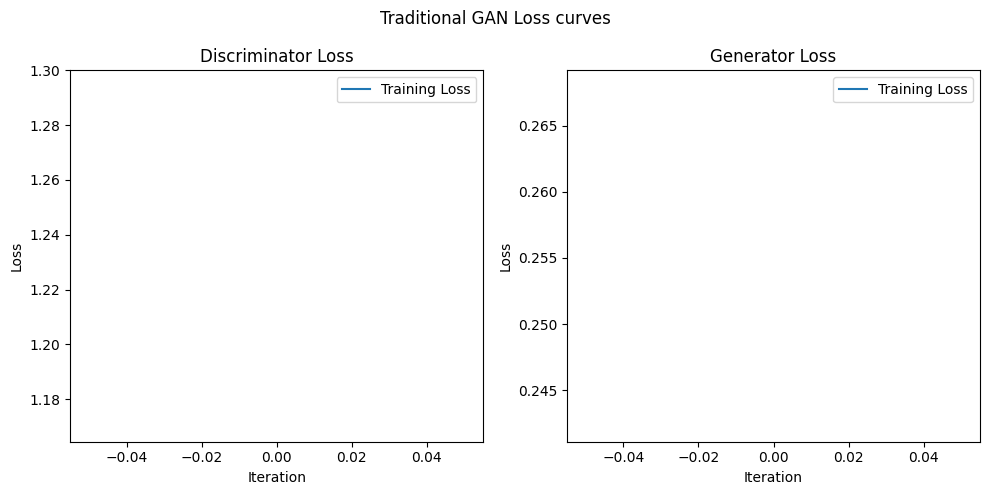

In [ ]:
plt.figure(figsize=(10, 5))


# Discriminator Loss
plt.subplot(1, 2, 1)
plt.plot(dt_losses, label='Training Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Discriminator Loss')
plt.ylim(0, 1)
plt.legend()

# Generator Loss
plt.subplot(1, 2, 2)
plt.plot(gt_losses, label='Training Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Generator Loss')
plt.ylim(0, 1)
plt.legend()

plt.suptitle('Traditional GAN Loss curves')

# plt.ylim(0, 60)
plt.tight_layout()
plt.show()

##Generating vectors for required number and recording the time taken to do so

In [ ]:
#Generator at 20000 iterations
current_time = datetime.now()
gen_data_size = 10000


noise = np.random.normal(0, 1, (gen_data_size, latent_dim))
synthetic_data = generator.predict(noise)
current_time_2 = datetime.now()

duration = current_time_2 - current_time
print(f"Generation duration: {duration}")

313/313 [==============================] - 6s 20ms/step
Generation duration: 0:00:06.784858


## Visualizing 1 Generated vector

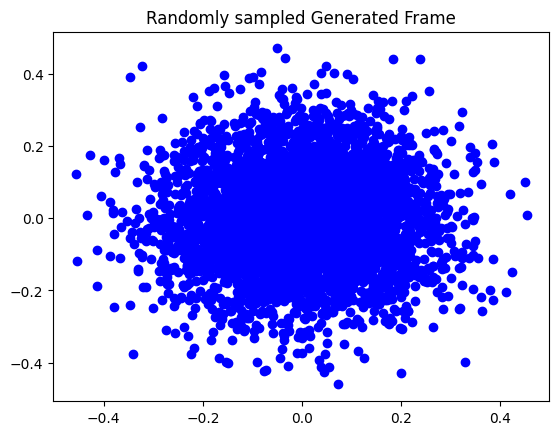

In [ ]:
I_gen = synthetic_data[2,range(0,synthetic_data.shape[1],2)]
Q_gen = synthetic_data[2,range(1,synthetic_data.shape[1]+1,2)]
plt.scatter(I_gen, Q_gen, c ="blue")
plt.title('Randomly sampled Generated Frame')

# To show the plot
plt.show()

## Visualizing 1 Real Vector from the Training vectors

Text(0.5, 1.0, 'Randomly sampled Real Frame')

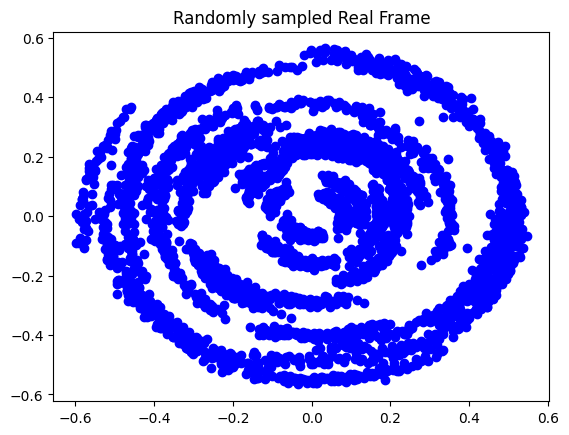

In [ ]:
I_r = train_r_frms[2,range(0,train_r_frms.shape[1],2)]
Q_r = train_r_frms[2,range(1,train_r_frms.shape[1]+1,2)]
plt.scatter(I_r, Q_r, c ="blue")
plt.title('Randomly sampled Real Frame')

## Function to separate corresponding I and Q samples from the LTS frames represented as vectors

In [ ]:
def I_Q_cal(data = None):
  if data is None:
     raise ValueError("No data is sent, i.e data = None")
  else:
    I = data[:,range(0,data.shape[1],2)]
    Q = data[:,range(1,data.shape[1]+1,2)]
  return I, Q

## Function to calculate Average Power of the LTS frames represented as vectors

In [ ]:
def avg_Power(data = None):
  if data is None:
     raise ValueError("No data is sent, i.e data = None")
  else:
    I, Q = I_Q_cal(data)
    P_IQ = I**2 + Q**2
    avg_P_p_f = np.mean(P_IQ, axis=-1)
    avg_P = np.mean(avg_P_p_f)

    return avg_P

## Function to calculate the Variance of the Power of the LTS frames represented as vectors

In [ ]:
def var_Power(data = None):
  if data is None:
     raise ValueError("No data is sent, i.e data = None")
  else:
    I, Q = I_Q_cal(data)
    P_IQ = I**2 + Q**2
    var_P_f = np.var(P_IQ, axis=-1)
    avg_v_P_f = np.mean(var_P_f)

    return avg_v_P_f

## Average Power of the Generated vectors

In [ ]:
avg_P_real_t = avg_Power(train_r_frms)
avg_P_gen_t = avg_Power(synthetic_data)
print(f"Average Power of real data: {avg_P_real_t}")
print(f"Average Power of generated data: {avg_P_gen_t}")

Average Power of real data: 0.0833221165437426
Average Power of generated data: 0.03416530787944794


## Variance of the Power of the Generated vectors

In [ ]:
var_P_real_t = var_Power(train_r_frms)
var_P_gen_t = var_Power(synthetic_data)
print(f"Average Variance of Power of frames of real data: {var_P_real_t}")
print(f"Average Variance of Power of frames of generated data: {var_P_gen_t}")

Average Variance of Power of frames of real data: 0.0035009620016092807
Average Variance of Power of frames of generated data: 0.0011881467653438449


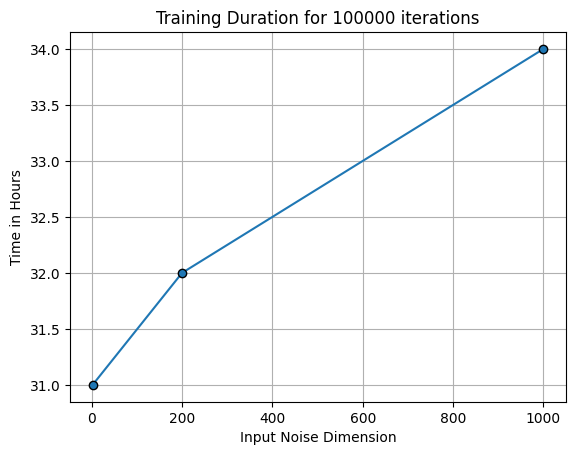

In [ ]:
plt.plot([2,200,1000], [31, 32, 34], marker='o', mec='black')
plt.xlabel('Input Noise Dimension')
plt.ylabel('Time in Hours')
plt.title('Training Duration for 100000 iterations')
# plt.legend()
plt.grid()

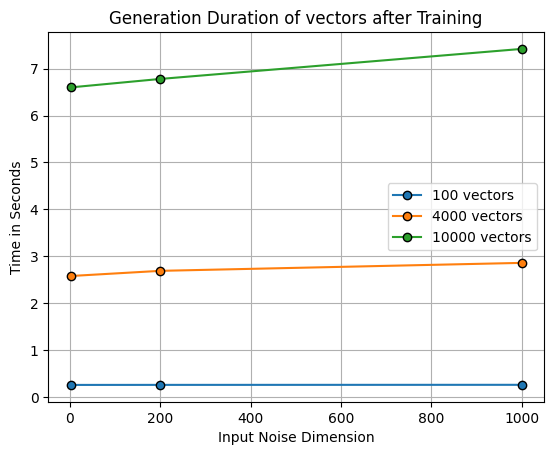

In [ ]:
plt.plot([2,200,1000], [0.2588, 0.2597, 0.2611], marker='o', mec='black',label='100 vectors')
plt.plot([2,200,1000], [2.58, 2.69, 2.86], marker='o', mec='black',label='4000 vectors')
plt.plot([2,200,1000], [6.60, 6.78, 7.42], marker='o', mec='black',label='10000 vectors')
plt.xlabel('Input Noise Dimension')
plt.ylabel('Time in Seconds')
plt.title('Generation Duration of vectors after Training')
plt.grid()
plt.legend()

## CDF of IQ Samples Power

In [ ]:
# load the generators with 1 iteration
generator1 = build_generator(latent_dim)
generator1.load_weights('generator_model_1iter.h5')
# load the generators with 60000 iterations
generator60000 = build_generator(latent_dim)
generator60000.load_weights('generator_model_60000iter.h5')


def P_IQ(data = None):
  if data is None:
     raise ValueError("No data is sent, i.e data = None")
  else:
    I, Q = I_Q_cal(data)
    P_IQ = I**2 + Q**2

    return P_IQ

gen_data_size = 4000
noise = np.random.normal(0, 1, (gen_data_size, latent_dim))
synthetic_data1 = generator1.predict(noise)
noise = np.random.normal(0, 1, (gen_data_size, latent_dim))
synthetic_data60000 = generator60000.predict(noise)

P_IQ_real = P_IQ(train_r_frms).reshape(4000*4096) # IQ Samples Power from real data (4000x4096 IQ samples)
P_IQ_synthetic1 = P_IQ(synthetic_data1).reshape(gen_data_size*4096) # IQ Samples Power from generated dat with 1 iteration (4000x4096 IQ samples)
P_IQ_synthetic60000 = P_IQ(synthetic_data60000).reshape(gen_data_size*4096) # IQ Samples Power from generated dat with 60000 iterations (4000x4096 IQ samples)


from scipy import stats
res_real = stats.ecdf(P_IQ_real)
ax = plt.subplot()
res_real.cdf.plot(ax, label = 'Real POWDER vectors')
res_gen2 = stats.ecdf(P_IQ_synthetic60000)
ax = plt.subplot()
res_gen2.cdf.plot(ax, label = 'Generated vectors: converged iteration')
res_gen1 = stats.ecdf(np.append(P_IQ_synthetic1,20))
ax = plt.subplot()
res_gen1.cdf.plot(ax, label = 'Generated vectors: initial iteration')
plt.xlim((0,1))
plt.legend()
plt.show()